### **Image Search Engine**

We are going to build our own image Search Engine. The dataset we are going to be using is the fllowing:
http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


4 steps of ISE: 


1. Defining your image descriptor: Decide what aspect of the image you want to describe, like color, texture, et... 
2. Indexing your dataset: Apply this image descriptor to each image in your dataset, extract features from these images, and write the features to storage so that they can be later compared for similarity.
3. Defining your similarity metric: Metric of comparision (cosine distance, chi-squared distance, euclidean distance,...) 
4. Searching: Perform an actual search. 


**STEP 1: IMAGE DESCRIPTOR** 
 

We have seen the image descriptor on color, by using RGB, but we will be analyzing also the HoG, which highlights the shape, and the LBP, for the texture. We will run them separately to see with which one we obtain better resulta, and then maybe we can concatenate some of them.

RGB Image descriptor

In [0]:
# import the necessary packages
import numpy as np
import cv2

class RGBHistogram:
	def __init__(self, bins):
		# store the number of bins the histogram will use
		self.bins = bins

	def describe(self, image):
		# compute a 3D histogram in the RGB colorspace,
		# then normalize the histogram so that images
		# with the same content, but either scaled larger
		# or smaller will have (roughly) the same histogram
		hist = cv2.calcHist([image], [0, 1, 2],
			None, self.bins, [0, 256, 0, 256, 0, 256])
		hist = cv2.normalize(hist,hist)
  
  

		# return out 3D histogram as a flattened array
		return hist.flatten()

HSV image descriptor: HSV is closer to how humans perceive color. It has three components: hue, saturation, and value.


In [0]:
import numpy as np
import cv2
import imutils

class HSVHistogram:
	def __init__(self, bins):
		# store the number of bins for the 3D histogram
		self.bins = bins

	def describe(self, image):
		# convert the image to the HSV color space and initialize
		# the features used to quantify the image
		image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
		hist = cv2.calcHist([image], [0, 1, 2], None, self.bins, [0, 180, 0, 256, 0, 256])
		hist = cv2.normalize(hist,hist)
    
		#features = []
		# grab the dimensions and compute the center of the image
		#(h, w) = image.shape[:2]
		#(cX, cY) = (int(w * 0.5), int(h * 0.5))
  
    # return out 3D histogram as a flattened array
		return hist.flatten()


## **STEP 2: Indexing our Dataset**

The next step is to apply our image descriptor to each image in the dataset.
This simply means that we are going to loop over our 204 image dataset, extract the histgram for RGB or HSV from each image, store the features in a dictionary, and write the dictionary to file.

In [3]:
# import the necessary packages
import pickle
import glob
import os

# Data names and locations
dataset_location = "/content/gdrive/My Drive/Colab Notebooks/LSMA/P2_Image_Audio_Feature_Engineering/img_redc"
index_name = "/content/gdrive/My Drive/Colab Notebooks/LSMA/P2_Image_Audio_Feature_Engineering/img_redc/rgb_histogram_index"

# initialize the index dictionary to store our our quantifed
# images, with the 'key' of the dictionary being the image
# filename and the 'value' our computed features
index = {}

# initialize our image descriptor -- a 3D RGB histogram with
# 8 bins per channel 
#	CHANGE RB/HSV HISTOGRAM DEPENDING ON CHOSEN IMAGEDESCRIPTOR
desc = RGBHistogram([8, 8, 8])

# use glob to grab the image paths and loop over them
for imagePath in glob.glob(dataset_location + os.sep + "*.jpg"):
	# extract our unique image ID (i.e. the filename)
	k = imagePath[imagePath.rfind(os.sep) + 1:]

	# load the image, describe it using our RGB histogram
	# descriptor, and update the index
	image = cv2.imread(imagePath)
	features = desc.describe(image)
	index[k] = features

# we are now done indexing our image -- now we can write our
# index to disk
outputFile = open(index_name +".pkl", "wb")
pickle.dump(index, outputFile)
outputFile.close()

pickle.dumps(index)

# show how many images we indexed
print("done...indexed %d images" % (len(index)))

done...indexed 204 images


## **STEP 3: Search**

We now have our index sitting on disk, ready to be searched.
Now we need to compare feature vector and decide their similarity, we have define 4 methods:
- Euclidean distance 
- Chi squared distance 
- Cosine similarity 
- Manhattan distance 

In [0]:
from math import*

class Searcher: 

  index =  {}

  def __init__(self, index):
    #store our index image
    self.index = index
  #np.ndarray
  def search (self, queryFeatures):
    #init dictionary of results
    result_dict = {}
    #loop over the index
    #print(index)
    for (k, features) in self.index.items():
      #d = self.__euclidean_distance(features, queryFeatures)
      #d = self.__manhattan_distance(features, queryFeatures)
      #print(queryFeatures)
      d = self.__cosine_similarity(features, queryFeatures)
      #d = self.__chi2_distance(features, queryFeatures)
      result_dict[k] = d

      results = sorted([(v,k) for (k,v) in result_dict.items()])
    return results

  def __chi2_distance(self, histA, histB, eps = 1e-10):
		#compute the chi-squared distance
    d = 0.5 * np.sum([((a - b)**2)/(a + b + eps) for (a, b) in zip(histA, histB)])
    #return the chi-squared distance
    return d

  def __euclidean_distance(self, histA, histB):
  # compute the euclidean
    d = sqrt(np.sum[(pow(a-b,2) for a, b in zip(histA, histB))])
    # return the euclidean distance
    return d

  def __square_rooted(self, histA):
    return round(sqrt(sum([a*a for a in histA])),2)

  def __cosine_similarity(self, histA, histB):
    numerator = np.sum([a*b for a,b in zip(histA, histB)])
    denominator = self.__square_rooted(histA)*self.__square_rooted(histB)
    d = round(numerator/float(denominator),2)
    return d

  def __manhattan_distance(self, histA, histB):
    d = np.sum([abs(a-b) for a,b in zip (histA, histB)])
    return d

## **STEP 4: Performing the Search**

Now we perform the image search, with the different metrics described in the Searcher class for both HSV and RGB. 

query: image_00073.jpg
	1. image_00183.jpg : 0.060
	2. image_00116.jpg : 0.070
	3. image_00122.jpg : 0.070
	4. image_00192.jpg : 0.070
	5. image_00067.jpg : 0.080
	6. image_00022.jpg : 0.090
	7. image_00018.jpg : 0.100
	8. image_00114.jpg : 0.100
	9. image_00202.jpg : 0.110
	10. image_00044.jpg : 0.120
query: image_00098.jpg
	1. image_00022.jpg : 0.020
	2. image_00116.jpg : 0.020
	3. image_00148.jpg : 0.020
	4. image_00192.jpg : 0.020
	5. image_00028.jpg : 0.030
	6. image_00067.jpg : 0.030
	7. image_00075.jpg : 0.030
	8. image_00088.jpg : 0.030
	9. image_00114.jpg : 0.030
	10. image_00122.jpg : 0.030


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


query: image_00067.jpg
	1. image_00121.jpg : 0.010
	2. image_00002.jpg : 0.020
	3. image_00107.jpg : 0.020
	4. image_00183.jpg : 0.020
	5. image_00029.jpg : 0.030
	6. image_00055.jpg : 0.030
	7. image_00098.jpg : 0.030
	8. image_00161.jpg : 0.030
	9. image_00016.jpg : 0.040
	10. image_00033.jpg : 0.040
query: image_00113.jpg
	1. image_00183.jpg : 0.030
	2. image_00104.jpg : 0.120
	3. image_00018.jpg : 0.140
	4. image_00098.jpg : 0.160
	5. image_00062.jpg : 0.200
	6. image_00022.jpg : 0.230
	7. image_00059.jpg : 0.230
	8. image_00121.jpg : 0.240
	9. image_00170.jpg : 0.240
	10. image_00188.jpg : 0.240
query: image_00064.jpg
	1. image_00183.jpg : 0.030
	2. image_00018.jpg : 0.040
	3. image_00022.jpg : 0.040
	4. image_00122.jpg : 0.060
	5. image_00044.jpg : 0.090
	6. image_00080.jpg : 0.090
	7. image_00192.jpg : 0.090
	8. image_00028.jpg : 0.110
	9. image_00116.jpg : 0.110
	10. image_00062.jpg : 0.120
query: image_00070.jpg
	1. image_00002.jpg : 0.030
	2. image_00183.jpg : 0.030
	3. image

KeyboardInterrupt: ignored

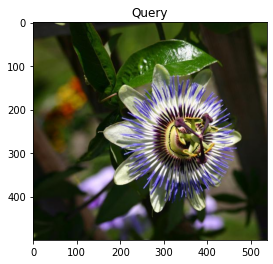

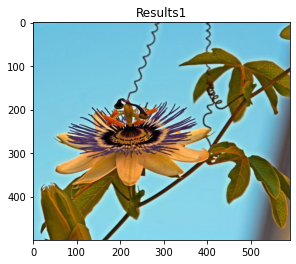

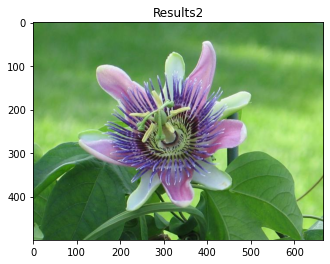

Error in callback <function flush_figures at 0x7f09aa915c80> (for post_execute):


KeyboardInterrupt: ignored

In [29]:
# import the necessary packages
import matplotlib.pyplot as plt
%matplotlib inline

# load the index and initialize our searcher
dataset_location = "/content/gdrive/My Drive/Colab Notebooks/LSMA/P2_Image_Audio_Feature_Engineering/img_redc"
index_name = "/content/gdrive/My Drive/Colab Notebooks/LSMA/P2_Image_Audio_Feature_Engineering/img_redc/rgb_histogram_index"

file = open(index_name +".pkl", 'rb')
index = pickle.load(file)
searcher = Searcher(index)


# loop over images in the index -- we will use each one as
# a query image
for (query, queryFeatures) in index.items():
    # perform the search using the current query
    results = searcher.search(queryFeatures)

    # load the query image and display it
    path = dataset_location + os.sep + query
    queryImage = cv2.imread(path)
    plt.figure()
    plt.title('Query')
    b, g, r = cv2.split(queryImage)
    queryImage = cv2.merge((r, g, b))
    plt.imshow(queryImage)
    print('query: %s' % (query))

  

    # loop over the top ten results
    for j in range(0, 10):
        # grab the result (we are using row-major order) and
        # load the result image
        (score, imageName) = results[j]
        path = dataset_location + os.sep + '%s' % (imageName)
        result = cv2.imread(path)
        print('\t%d. %s : %.3f' % (j + 1, imageName, score))
        # show the results
        plt.figure()
        plt.title('Results' + str(j+1))
        b, g, r = cv2.split(result)
        result = cv2.merge((r, g, b))
        plt.imshow(result)

## **Results**

**Chi-squared:**

RGB image_00073.jpg 1. image_00073.jpg : 0.000 2. image_00015.jpg : 0.391 3. image_00091.jpg : 0.433 4. image_00182.jpg : 0.443 5. image_00051.jpg : 0.445 6. image_00118.jpg : 0.464 7. image_00177.jpg : 0.481 8. image_00196.jpg : 0.492 9. image_00049.jpg : 0.521 10. image_00152.jpg : 0.548

HSV query: image_00073.jpg 1. image_00073.jpg : 0.000 2. image_00091.jpg : 1.929 3. image_00182.jpg : 1.932 4. image_00177.jpg : 2.011 5. image_00158.jpg : 2.111 6. image_00049.jpg : 2.123 7. image_00118.jpg : 2.191 8. image_00015.jpg : 2.197 9. image_00133.jpg : 2.298 10. image_00196.jpg : 2.389

**Manhattan distance**

RGB
  query: image_00073.jpg
	1. image_00073.jpg : 0.000
	2. image_00051.jpg : 1.421
	3. image_00182.jpg : 1.553
	4. image_00015.jpg : 1.585
	5. image_00091.jpg : 1.723
	6. image_00118.jpg : 1.751
	7. image_00177.jpg : 1.778
	8. image_00196.jpg : 1.893
	9. image_00030.jpg : 1.918
	10. image_00049.jpg : 1.924	

HSV
query: image_00073.jpg
	1. image_00073.jpg : 0.000
	2. image_00182.jpg : 6.142
	3. image_00177.jpg : 6.304
	4. image_00091.jpg : 6.467
	5. image_00049.jpg : 6.537
	6. image_00195.jpg : 7.096
	7. image_00196.jpg : 7.116
	8. image_00133.jpg : 7.132
	9. image_00118.jpg : 7.242
	10. image_00158.jpg : 7.248

**Cosine Similarity**


RGB
query: image_00073.jpg
	1. image_00183.jpg : 0.060
	2. image_00116.jpg : 0.070
	3. image_00122.jpg : 0.070
	4. image_00192.jpg : 0.070
	5. image_00067.jpg : 0.080
	6. image_00022.jpg : 0.090
	7. image_00018.jpg : 0.100
	8. image_00114.jpg : 0.100
	9. image_00202.jpg : 0.110
	10. image_00044.jpg : 0.120


HSV
query: image_00073.jpg
	1. image_00157.jpg : 0.030
	2. image_00183.jpg : 0.030
	3. image_00116.jpg : 0.040
	4. image_00075.jpg : 0.050
	5. image_00122.jpg : 0.060
	6. image_00037.jpg : 0.080
	7. image_00067.jpg : 0.080
	8. image_00117.jpg : 0.080
	9. image_00202.jpg : 0.080
	10. image_00022.jpg : 0.090



## **HOG Image Descriptor** 

RGB
query: image_00073.jpg
	1. image_00183.jpg : 0.060
	2. image_00116.jpg : 0.070
	3. image_00122.jpg : 0.070
	4. image_00192.jpg : 0.070
	5. image_00067.jpg : 0.080
	6. image_00022.jpg : 0.090
	7. image_00018.jpg : 0.100
	8. image_00114.jpg : 0.100
	9. image_00202.jpg : 0.110
	10. image_00044.jpg : 0.120

HoG descriptor: HOG descriptors are mainly used to describe the structural shape and appearance of an object in an image. However, since HOG captures local intensity gradients and edge directions, it also makes for a good texture descriptor.


1. We are going to convert the images to grayscale in another folder. 


In [5]:
import cv2
from os import listdir,makedirs
from os.path import isfile,join

path = '/content/gdrive/My Drive/Colab Notebooks/LSMA/P2_Image_Audio_Feature_Engineering/img_redc' # Source Folder
dstpath = '/content/gdrive/My Drive/Colab Notebooks/LSMA/P2_Image_Audio_Feature_Engineering/img_redc_gray' # Destination Folder

try:
    makedirs(dstpath)
except:
    print ("Directory already exist, images will be written in asme folder")

# Folder won't used
files = [f for f in listdir(path) if isfile(join(path,f))] 

for image in files:
    try:
        img = cv2.imread(os.path.join(path,image))
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        dstPath = join(dstpath,image)
        cv2.imwrite(dstPath,gray)
    except:
        print ("{} is not converted".format(image))

Directory already exist, images will be written in asme folder
rgb_histogram_index.pkl is not converted
HSV_histogram_index.pkl is not converted
hsv_histogram_index.pkl is not converted


2. We will define our HOGImage descriptor 

In [0]:
import matplotlib.pyplot as plt

from skimage.feature import hog
from skimage import data, exposure
import numpy as np

class HOGImage:

  features = []
  hog_image = None
  original_image = None

  def __init__(self, image):
    if not os.path.exists(image):
      raise Exception("Input image not found in path.")
    img = cv2.imread(image)
    self.original_image = resize(img, (512,512))

  def compute_hog_image(self):
    fd, image = hog(self.original_image, orientations=8, pixels_per_cell=(16, 16),
                        cells_per_block=(1, 1), visualize=True, multichannel=True)
    self.features = fd
    self.hog_image = image
  
  def show(self):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

    if self.original_image is not None:
      self.__plot_image(self.original_image, ax1, "Origianl Image")

    if self.hog_image is not None:
      hog_image_rescaled = exposure.rescale_intensity(self.hog_image, in_range=(0, 10))
      self.__plot_image(hog_image_rescaled, ax2, "HOG Image")
    
    plt.show()


  def __plot_image(self, image,  axis, title):
    axis.axis('off')
    axis.imshow(image, cmap=plt.cm.gray)
    axis.set_title(title)

3. Once we have defined our HogImage descriptor, we are going to apply it in all 204 images, in order to obtain the HogImage and the features.  

## **STEP 2: Indexing dataset**
We will also generate our .pickle with the indexed dataset. 

In [49]:
from skimage.transform import resize
import os
import fnmatch
import pickle
import glob


path_to_folder = os.path.join(os.path.sep,'content','gdrive','My Drive','Colab Notebooks','LSMA', 'P2_Image_Audio_Feature_Engineering','img_redc_gray')
index = {}
index_name = "/content/gdrive/My Drive/Colab Notebooks/LSMA/P2_Image_Audio_Feature_Engineering/img_redc_gray/hog_histogram_index"

for path,dirs,files in os.walk(path_to_folder):
   for f in fnmatch.filter(files,'*.jpg'):
       fullname = os.path.abspath(os.path.join(path,f))
       #print(fullname)
       imag = HOGImage(fullname)
       imag.compute_hog_image()
       imag.show()
       features_imag = imag.features
       #print(resized_img.shape)  

       k = fullname[fullname.rfind(os.sep) + 1:]
       index[k] = features_imag
       print(index[k])
       # we are now done indexing our image -- now we can write our
       # index to disk
       outputFile = open(index_name +".pkl", "wb")
       pickle.dump(index, outputFile)
       outputFile.close()

       pickle.dumps(index)

       # show how many images we indexed
       print("done...indexed %d images" % (len(index)))
       

Output hidden; open in https://colab.research.google.com to view.

## **STEP 3: Search**

We now have our index sitting on disk, ready to be searched.
Now we need to compare feature vector and decide their similarity, we have define 4 methods:
- Euclidean distance 
- Chi squared distance 
- Cosine similarity 
- Manhattan distance 

In [0]:
from math import*

class Searcher: 

  index =  {}

  def __init__(self, index):
    #store our index image
    self.index = index
  #np.ndarray
  def search (self, queryFeatures):
    #init dictionary of results
    result_dict = {}
    #loop over the index
    #print(index)
    for (k, features) in self.index.items():
      #d = self.__euclidean_distance(features, queryFeatures)
      #d = self.__manhattan_distance(features, queryFeatures)
      #print(queryFeatures)
      d = self.__cosine_similarity(features, queryFeatures)
      #d = self.__chi2_distance(features, queryFeatures)
      result_dict[k] = d

      results = sorted([(v,k) for (k,v) in result_dict.items()])
    return results

  def __chi2_distance(self, histA, histB, eps = 1e-10):
		#compute the chi-squared distance
    d = 0.5 * np.sum([((a - b)**2)/(a + b + eps) for (a, b) in zip(histA, histB)])
    #return the chi-squared distance
    return d

  def __euclidean_distance(self, histA, histB):
  # compute the euclidean
    d = sqrt(np.sum[(pow(a-b,2) for a, b in zip(histA, histB))])
    # return the euclidean distance
    return d

  def __square_rooted(histA):
    return round(sqrt(sum([a*a for a in histA])),2)

  def __cosine_similarity(self, histA, histB):
    numerator = np.sum([a*b for a,b in zip(histA, histB)])
    denominator = self.__square_rooted(histA)*self.__square_rooted(histB)
    d = round(numerator/float(denominator),2)
    return d

  def __manhattan_distance(self, histA, histB):
    d = np.sum([abs(a-b) for a,b in zip (histA, histB)])
    return d

## **STEP 4: Performing the search**

query: image_00073.jpg
	1. image_00073.jpg : 0.000
	2. image_00114.jpg : 1358.870
	3. image_00045.jpg : 1378.496
	4. image_00090.jpg : 1381.333
	5. image_00040.jpg : 1382.723
	6. image_00028.jpg : 1383.719
	7. image_00027.jpg : 1384.938
	8. image_00119.jpg : 1385.134
	9. image_00170.jpg : 1391.811
	10. image_00026.jpg : 1392.991
query: image_00098.jpg
	1. image_00098.jpg : 0.000
	2. image_00114.jpg : 1205.750
	3. image_00139.jpg : 1206.720
	4. image_00027.jpg : 1235.042
	5. image_00070.jpg : 1244.939
	6. image_00090.jpg : 1252.070
	7. image_00038.jpg : 1260.872
	8. image_00198.jpg : 1263.837
	9. image_00023.jpg : 1265.453
	10. image_00164.jpg : 1270.998


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


query: image_00067.jpg
	1. image_00067.jpg : 0.000
	2. image_00070.jpg : 1098.329
	3. image_00027.jpg : 1144.026
	4. image_00114.jpg : 1147.641
	5. image_00139.jpg : 1160.752
	6. image_00096.jpg : 1166.919
	7. image_00090.jpg : 1171.957
	8. image_00204.jpg : 1175.073
	9. image_00126.jpg : 1185.660
	10. image_00164.jpg : 1193.547
query: image_00113.jpg
	1. image_00113.jpg : 0.000
	2. image_00033.jpg : 1199.878
	3. image_00185.jpg : 1220.429
	4. image_00173.jpg : 1220.950
	5. image_00114.jpg : 1235.481
	6. image_00070.jpg : 1246.296
	7. image_00045.jpg : 1248.097
	8. image_00028.jpg : 1248.249
	9. image_00138.jpg : 1248.288
	10. image_00119.jpg : 1260.837
query: image_00064.jpg
	1. image_00064.jpg : 0.000
	2. image_00010.jpg : 1077.693
	3. image_00070.jpg : 1145.912
	4. image_00088.jpg : 1195.705
	5. image_00093.jpg : 1204.721
	6. image_00114.jpg : 1215.371
	7. image_00156.jpg : 1219.343
	8. image_00130.jpg : 1228.601
	9. image_00090.jpg : 1236.747
	10. image_00021.jpg : 1247.467
query: 

KeyboardInterrupt: ignored

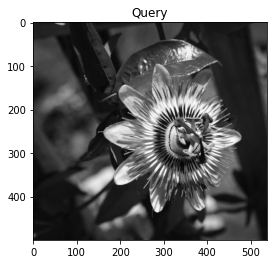

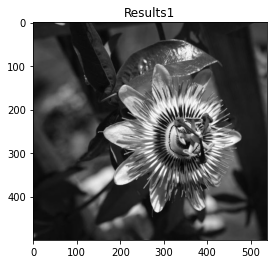

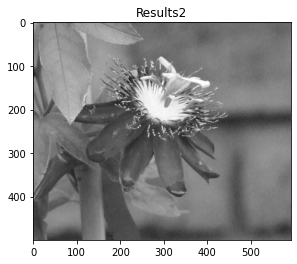

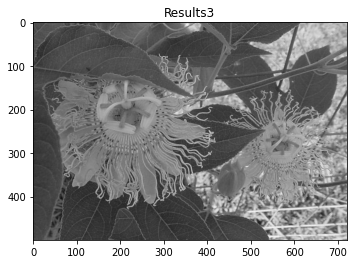

Error in callback <function flush_figures at 0x7f9fce7acc80> (for post_execute):


KeyboardInterrupt: ignored

In [143]:
# import the necessary packages
import matplotlib.pyplot as plt
%matplotlib inline

# load the index and initialize our searcher
dataset_location = "/content/gdrive/My Drive/Colab Notebooks/LSMA/P2_Image_Audio_Feature_Engineering/img_redc_gray"
index_name = "/content/gdrive/My Drive/Colab Notebooks/LSMA/P2_Image_Audio_Feature_Engineering/img_redc_gray/hog_histogram_index"

file = open(index_name +'.pkl', 'rb')
index = pickle.load(file)
searcher = Searcher(index)

# loop over images in the index -- we will use each one as
# a query image
for (query, queryFeatures) in index.items():
    # perform the search using the current query
    results = searcher.search(queryFeatures)

    # load the query image and display it
    path = dataset_location + os.sep + query
    queryImage = cv2.imread(path)
    plt.figure()
    plt.title('Query')
    b, g, r = cv2.split(queryImage)
    queryImage = cv2.merge((r, g, b))
    plt.imshow(queryImage)
    print('query: %s' % (query))

  

    # loop over the top ten results
    for j in range(0, 10):
        # grab the result (we are using row-major order) and
        # load the result image
        (score, imageName) = results[j]
        path = dataset_location + os.sep + '%s' % (imageName)
        result = cv2.imread(path)
        print('\t%d. %s : %.3f' % (j + 1, imageName, score))
        # show the results
        plt.figure()
        plt.title('Results' + str(j+1))
        b, g, r = cv2.split(result)
        result = cv2.merge((r, g, b))
        plt.imshow(result)
          

## **Results**

## **CHI Distance**
 
 RGB
 image_00073.jpg
	1. image_00073.jpg : 0.000
	2. image_00015.jpg : 0.391
	3. image_00091.jpg : 0.433
	4. image_00182.jpg : 0.443
	5. image_00051.jpg : 0.445
	6. image_00118.jpg : 0.464
	7. image_00177.jpg : 0.481
	8. image_00196.jpg : 0.492
	9. image_00049.jpg : 0.521
	10. image_00152.jpg : 0.548


HOG
query: image_00073.jpg
	1. image_00073.jpg : 0.000
	2. image_00114.jpg : 327.982
	3. image_00090.jpg : 337.218
	4. image_00028.jpg : 338.611
	5. image_00027.jpg : 339.321
	6. image_00164.jpg : 340.501
	7. image_00045.jpg : 340.687
	8. image_00070.jpg : 341.172
	9. image_00170.jpg : 341.772
	10. image_00119.jpg : 341.995

HSV
query: image_00073.jpg
	1. image_00073.jpg : 0.000
	2. image_00091.jpg : 1.929
	3. image_00182.jpg : 1.932
	4. image_00177.jpg : 2.011
	5. image_00158.jpg : 2.111
	6. image_00049.jpg : 2.123
	7. image_00118.jpg : 2.191
	8. image_00015.jpg : 2.197
	9. image_00133.jpg : 2.298
	10. image_00196.jpg : 2.389


## **Cosine similarity Distance**

RGB
query: image_00073.jpg
	1. image_00183.jpg : 0.060
	2. image_00116.jpg : 0.070
	3. image_00122.jpg : 0.070
	4. image_00192.jpg : 0.070
	5. image_00067.jpg : 0.080
	6. image_00022.jpg : 0.090
	7. image_00018.jpg : 0.100
	8. image_00114.jpg : 0.100
	9. image_00202.jpg : 0.110
	10. image_00044.jpg : 0.120


HOG
query: image_00073.jpg
	1. image_00157.jpg : 0.590
	2. image_00104.jpg : 0.700
	3. image_00084.jpg : 0.720
	4. image_00144.jpg : 0.720
	5. image_00158.jpg : 0.720
	6. image_00183.jpg : 0.720
	7. image_00001.jpg : 0.730
	8. image_00016.jpg : 0.740
	9. image_00030.jpg : 0.740
	10. image_00039.jpg : 0.740

HSV
query: image_00073.jpg
	1. image_00157.jpg : 0.030
	2. image_00183.jpg : 0.030
	3. image_00116.jpg : 0.040
	4. image_00075.jpg : 0.050
	5. image_00122.jpg : 0.060
	6. image_00037.jpg : 0.080
	7. image_00067.jpg : 0.080
	8. image_00117.jpg : 0.080
	9. image_00202.jpg : 0.080
	10. image_00022.jpg : 0.090





## **Manhattan Distance**

RGB
  query: image_00073.jpg
	1. image_00073.jpg : 0.000
	2. image_00051.jpg : 1.421
	3. image_00182.jpg : 1.553
	4. image_00015.jpg : 1.585
	5. image_00091.jpg : 1.723
	6. image_00118.jpg : 1.751
	7. image_00177.jpg : 1.778
	8. image_00196.jpg : 1.893
	9. image_00030.jpg : 1.918
	10. image_00049.jpg : 1.924	

HOG
query: image_00073.jpg
	1. image_00073.jpg : 0.000
	2. image_00114.jpg : 1358.870
	3. image_00045.jpg : 1378.496
	4. image_00090.jpg : 1381.333
	5. image_00040.jpg : 1382.723
	6. image_00028.jpg : 1383.719
	7. image_00027.jpg : 1384.938
	8. image_00119.jpg : 1385.134
	9. image_00170.jpg : 1391.811
	10. image_00026.jpg : 1392.991

HSV
query: image_00073.jpg
	1. image_00073.jpg : 0.000
	2. image_00182.jpg : 6.142
	3. image_00177.jpg : 6.304
	4. image_00091.jpg : 6.467
	5. image_00049.jpg : 6.537
	6. image_00195.jpg : 7.096
	7. image_00196.jpg : 7.116
	8. image_00133.jpg : 7.132
	9. image_00118.jpg : 7.242
	10. image_00158.jpg : 7.248

## **Conclusions**



I found this lab quite interesting, as we could see how different searching metrics generate different searches. I had some trouble implementing the HOG image descriptor, as I don't really work with methods, so it was quite a challenge defining each method. I also had some problmes in the search metrics, specially with the different object types, it was confusing what type was each object, a list, a dictionary, ndarray,.... 

As for the results, I just extracted the one for the same query image, 73, in order to compare and see which was is better. 

HSV and RGB: 
When we did the searching image, with the manhattan distance, the chi-squared and the cosine similarity we obtained similar results, most of our searched image were the same, which suggest that this search metric works well with this image_descriptor, as the results were also good.  


HOG: 
We obtianed similar results for the manhattan and chi squared metric too. 



